In [1]:
from sys import path

path.append("../")

from src.utils.statistical_analysis import (
    load_and_prepare_data,
    compute_statistics,
    make_plot,
)

In [2]:
from numpy import sqrt, ndarray
from scipy import stats
from statsmodels.stats.multitest import multipletests

def custom_t_test_correlation(correlation_values: ndarray, n: int, alpha: int = 0.05):
    """
    Perform a t-test on the correlation values.

    Args:
        correlation_values (DataFrame): The correlation values.
        n (int): The number of samples.

    Returns:
        float: The t-statistic.
        float: The p-value.
    """

    initial_shape = correlation_values.shape
    correlation_values = correlation_values.reshape(-1)
    t: ndarray = (correlation_values * (n-2)**0.5)/(sqrt(1-correlation_values**2))
    # get pvalues from t
    pval = stats.t.sf(abs(t), n-2) * 2
    multi_hypothesis_result = multipletests(
    pval,
    alpha=0.05,
    method="holm",
)   
    pvals_corrected = multi_hypothesis_result[1]
    below_threshold = pvals_corrected < alpha

    return t.reshape(initial_shape), pvals_corrected.reshape(initial_shape), below_threshold.reshape(initial_shape)

# MWC2022

In [3]:
n_tot = 4873

In [4]:
path_to_data = "../data.nosync/mwc2022/results/correlation_rl_features_complete-3.json"
values_w_intervals, feature_names = load_and_prepare_data(path_to_data)

In [5]:
from pandas import DataFrame


t_vals, p_vals, below_thresholds = custom_t_test_correlation(
    values_w_intervals.iloc[:, :2].values, n_tot
)
below_thresholds = DataFrame(
    below_thresholds, index=values_w_intervals.index
)
from pandas import concat, MultiIndex
below_thresholds.columns = MultiIndex.from_product([["negative", "positive"], ['below_threshold']])
values_w_intervals = concat([values_w_intervals, below_thresholds], axis=1)

In [7]:
pvalues = compute_statistics(
    values_w_intervals=values_w_intervals, events=["Cognitive Load", "Relaxation"]
)

Average cliff δ for Cognitive Load: 0.47
Average cliff δ for Relaxation: 0.44
Percentage of intervals where Cognitive Load has larger cliff δ values: 44.44%
Percentage of intervals where Relaxation has larger cliff δ values: 15.56%
Percentage of intervals where there is no difference: 40.00%


/Users/leonardoalchieri/Desktop/GIT/LateralizationPhysiologicalWearables/plotting_notebooks/../src/utils/statistical_analysis.py:218: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


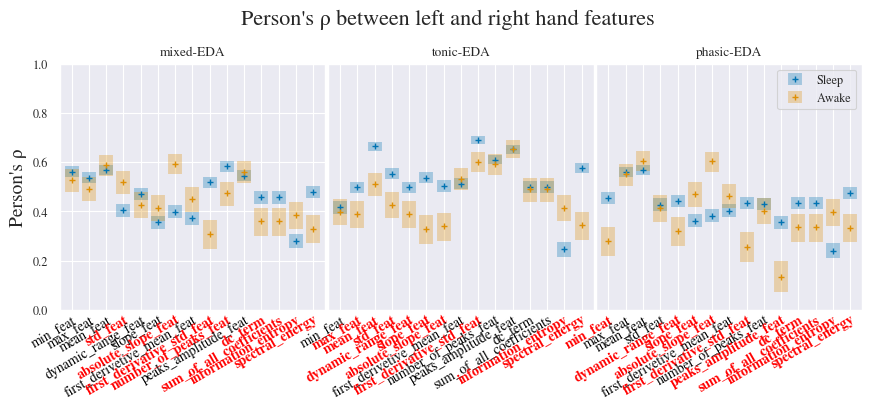

In [8]:

make_plot(
    values_w_intervals,
    "../final_visualizations/correlation_rl_complete-mwc2022.pdf",
    feature_names,
    classes_list=["Sleep", "Awake"],
    measure_name="Person's ρ",
    plot_title="Person's ρ between left and right hand features",
    ylim=[0, 1],
    make_thresholds=False,
    marker='below_threshold',
)


# USILaughs

In [3]:
n_tot = 810

In [4]:
path_to_data = "../data.nosync/usilaughs/results/correlation_rl_features_complete-3.json"
values_w_intervals, feature_names = load_and_prepare_data(path_to_data)

In [5]:
from pandas import DataFrame


t_vals, p_vals, below_thresholds = custom_t_test_correlation(
    values_w_intervals.iloc[:, :2].values, n_tot
)
below_thresholds = DataFrame(
    below_thresholds, index=values_w_intervals.index
)
from pandas import concat, MultiIndex
below_thresholds.columns = MultiIndex.from_product([["negative", "positive"], ['below_threshold']])
values_w_intervals = concat([values_w_intervals, below_thresholds], axis=1)

In [6]:
pvalues = compute_statistics(values_w_intervals=values_w_intervals, events=['Cognitive Load', 'Relaxation'])

Average cliff δ for Cognitive Load: 0.37
Average cliff δ for Relaxation: 0.46
Percentage of intervals where Cognitive Load has larger cliff δ values: 0.00%
Percentage of intervals where Relaxation has larger cliff δ values: 22.73%
Percentage of intervals where there is no difference: 77.27%


In [7]:
from pandas import concat, MultiIndex

# concate the pvalues results
pvalues.columns = MultiIndex.from_product([pvalues.columns, ['']])
values_w_intervals = concat([values_w_intervals, pvalues], axis=1)

/Users/leonardoalchieri/Desktop/GIT/LateralizationPhysiologicalWearables/plotting_notebooks/../src/utils/statistical_analysis.py:218: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


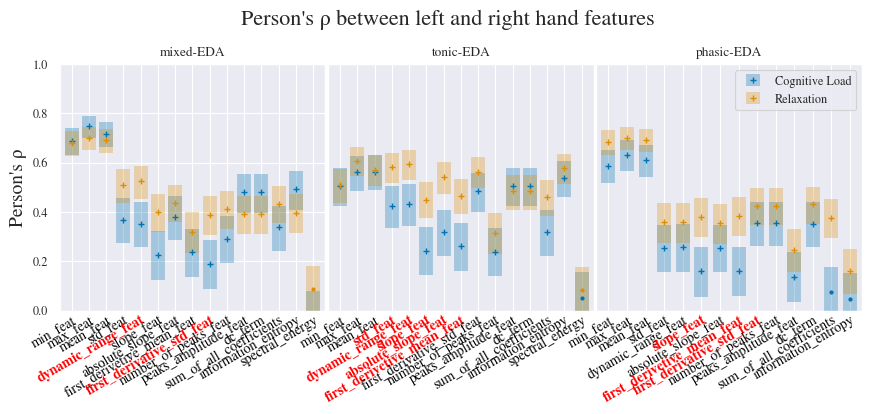

In [8]:
make_plot(
    values_w_intervals,
    "../final_visualizations/correlation_rl_complete-usilaughs.pdf",
    feature_names,
    classes_list=["Cognitive Load", "Relaxation"],
    measure_name="Person's ρ",
    plot_title="Person's ρ between left and right hand features",
    ylim=[0, 1],
    make_thresholds=False,
    marker='below_threshold',
    # marker='above_threshold',
)